In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from brush import BrushSlabs
import numpy as np
from lmfit import Parameters, printfuncs
from refnx.analysis import Transform, CurveFitter
from refnx.dataset import ReflectDataset
%matplotlib inline
import matplotlib.pyplot as plt
import corner

In [3]:
# # load the dataset
# Q, R, dR, dQ = np.loadtxt('100mMSCN20.txt', unpack=True)
# data = tuple((Q.tolist(), R.tolist(), dR.tolist(), dQ.tolist()))
# #NB d = ReflectDataset('example.txt') work if reduction done in refnx
# d = ReflectDataset(data)
d = ReflectDataset('c_PLP0025985.dat')

In [4]:
d.y_err

array([  6.38491980e-02,   6.31059382e-02,   4.89869989e-02,
         4.31303523e-02,   3.86704696e-02,   3.53100836e-02,
         3.06453292e-02,   2.73612437e-02,   2.36531805e-02,
         2.23516811e-02,   1.98972682e-02,   1.68632116e-02,
         1.52801681e-02,   1.37485192e-02,   1.25274376e-02,
         9.50349645e-03,   6.46399126e-03,   4.32501135e-03,
         2.96998339e-03,   2.11822547e-03,   1.60923676e-03,
         1.28645788e-03,   1.05898690e-03,   8.80130443e-04,
         7.33901147e-04,   6.26840611e-04,   5.30103753e-04,
         4.63125903e-04,   3.93608201e-04,   3.42367148e-04,
         3.02066613e-04,   2.65533111e-04,   2.31561055e-04,
         2.04547054e-04,   1.78953723e-04,   1.58056737e-04,
         1.41546423e-04,   1.27790125e-04,   1.12810016e-04,
         1.03732005e-04,   9.23886004e-05,   8.27366891e-05,
         7.28150691e-05,   6.55337309e-05,   5.79817484e-05,
         5.36559596e-05,   4.83164769e-05,   4.42278685e-05,
         3.99014760e-05,

In [5]:
t = Transform('logY').transform

In [6]:
# Transform the data to log R
# d.y, d.y_err = t(d.x, d.y, d.y_err)

In [7]:
#Initialise BrushSlabs Class
a = BrushSlabs(0.96, 1, n_slices=50, dq=8.85)

In [8]:
#List parameter names
a.parameter_names()

['scale',
 'bkg',
 'SLD_super',
 'SLD_sub',
 'thickness_SiO2',
 'SLD_SiO2',
 'roughness_SiO2',
 'roughness_backing',
 'thickness_1',
 'phi_1',
 'roughness_1']

In [9]:
#Set up values parameters object and fill with appropriate values
P = Parameters()

vals = [0.95, 1.55e-7, 2.07, 6.22, 16, 3.83, 3, 15.8,
            154.379, 0.91, 2]
lbs = [0.93, 1e-7, 2.06, 5.8, 5, 3, 2.9, 2,
            100, 0.1, 1.8 ]
ubs = [0.97, 1e-6, 2.08, 6.36, 25, 4, 3.6, 25,
            250, 1.0, 5]
varies = np.array([True] * 11, bool)
varies[[0, 2, 4, 5, 6, 10]] = False

for name, val, vary, lb, ub in zip(a.parameter_names(), vals, varies, lbs, ubs):
    P.add(name, val, vary, lb, ub)

In [10]:
#Generate slab parameters and check that appropriate number generated
slab_pars = a.to_slab(P)
assert(slab_pars[0] * 4 + 8 == np.size(slab_pars))

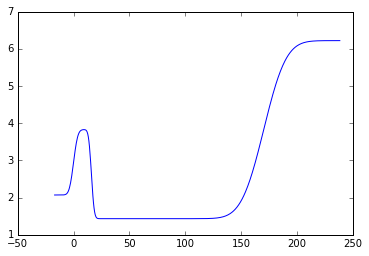

In [11]:
#Generate and plot SLD profile of initial parameters
z1, rho = a.sld_profile(P)
plt.plot(z1,rho)

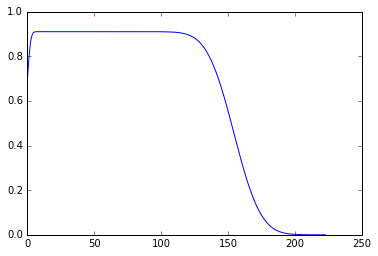

In [12]:
#Generate and plot volume fraction profile of initial parameters
z2, phi = a.vol_fraction(P)
plt.plot(z2,phi)

In [13]:
#Calculate and print area of intitial profile
area = a.vfp_area(P)
print(area)

140.121328142


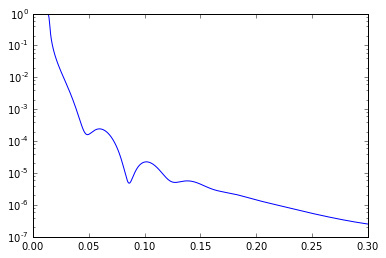

In [14]:
#Calculate and plot simulated reflectivity
q = np.linspace(0.01, 0.3, 1000)
ref = a.model(q, P)
plt.plot(q, ref)
plt.yscale('log')

In [15]:
# Set up curve-fitting object with model, data and parameters
b = CurveFitter(a, d, P)

In [16]:
#Fit data
c = b.fit('differential_evolution',tol=0.001)

In [17]:
#Pritn Fit Report
print(printfuncs.fit_report(c))

[[Fit Statistics]]
    # function evals   = 2914
    # data points      = 122
    # variables        = 5
    chi-square         = 753.273
    reduced chi-square = 6.438
    Akaike info crit   = 237.195
    Bayesian info crit = 251.215
[[Variables]]
    scale:               0.95 (fixed)
    bkg:                 3.2454e-07 (init= 1.55e-07)
    SLD_super:           2.07 (fixed)
    SLD_sub:             6.21771681 (init= 6.22)
    thickness_SiO2:      16 (fixed)
    SLD_SiO2:            3.83 (fixed)
    roughness_SiO2:      3 (fixed)
    roughness_backing:   15.8632366 (init= 15.8)
    thickness_1:         154.439820 (init= 154.379)
    phi_1:               0.90907464 (init= 0.91)
    roughness_1:         2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)


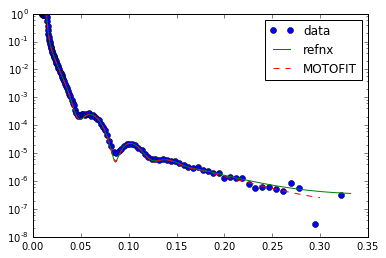

In [18]:
#Plot fit and original data
fit_ref = a.model(d.x,c.params)
plt.plot(d.x,d.y,'o',label='data')
plt.plot(d.x,fit_ref,'-',label='refnx')
plt.plot(q,ref,'--',label='MOTOFIT')
plt.yscale('log')
plt.legend()

In [19]:
#Check parameters
c.params

Parameters([('scale',
             <Parameter 'scale', value=0.95 (fixed), bounds=[0.93:0.97]>),
            ('bkg',
             <Parameter 'bkg', 3.2453639525038026e-07, bounds=[1e-07:1e-06]>),
            ('SLD_super',
             <Parameter 'SLD_super', value=2.07 (fixed), bounds=[2.06:2.08]>),
            ('SLD_sub',
             <Parameter 'SLD_sub', 6.2177168108915764, bounds=[5.8:6.36]>),
            ('thickness_SiO2',
             <Parameter 'thickness_SiO2', value=16 (fixed), bounds=[5:25]>),
            ('SLD_SiO2',
             <Parameter 'SLD_SiO2', value=3.83 (fixed), bounds=[3:4]>),
            ('roughness_SiO2',
             <Parameter 'roughness_SiO2', value=3 (fixed), bounds=[2.9:3.6]>),
            ('roughness_backing',
             <Parameter 'roughness_backing', 15.863236672007616, bounds=[2:25]>),
            ('thickness_1',
             <Parameter 'thickness_1', 154.43982029497195, bounds=[100:250]>),
            ('phi_1',
             <Parameter 'phi_1', 0.9090

In [20]:
#Check integrated area
a.vfp_area(c.params)

140.03431231321233

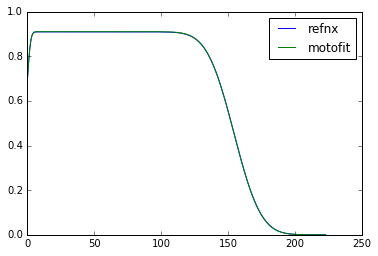

In [21]:
#Plot volume fraction profile and compare to initial parameters from MOTOFIT
z, rho = a.vol_fraction(c.params)
plt.plot(z,rho,label='refnx')
plt.plot(z2,phi,label='motofit')
plt.legend()

In [22]:
e = b.emcee()

In [23]:
#Print Fit Report
print(printfuncs.fit_report(e))

[[Fit Statistics]]
    # function evals   = 0
    # data points      = unknown
    # variables        = 5
    chi-square         = unknown
    reduced chi-square = unknown
    Akaike info crit   = unknown
    Bayesian info crit = unknown
[[Variables]]
    scale:               0.95 (fixed)
    bkg:                 3.2328e-07 +/- 3.16e-08 (9.78%) (init= 3.245364e-07)
    SLD_super:           2.07 (fixed)
    SLD_sub:             6.21671237 +/- 0.006056 (0.10%) (init= 6.217717)
    thickness_SiO2:      16 (fixed)
    SLD_SiO2:            3.83 (fixed)
    roughness_SiO2:      3 (fixed)
    roughness_backing:   15.8738515 +/- 0.096092 (0.61%) (init= 15.86324)
    thickness_1:         154.429031 +/- 0.161756 (0.10%) (init= 154.4398)
    phi_1:               0.90941377 +/- 0.001894 (0.21%) (init= 0.9090746)
    roughness_1:         2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(SLD_sub, phi_1)            = -0.754 
    C(roughness_backing, phi_1)  =  0.639 
    C(thick

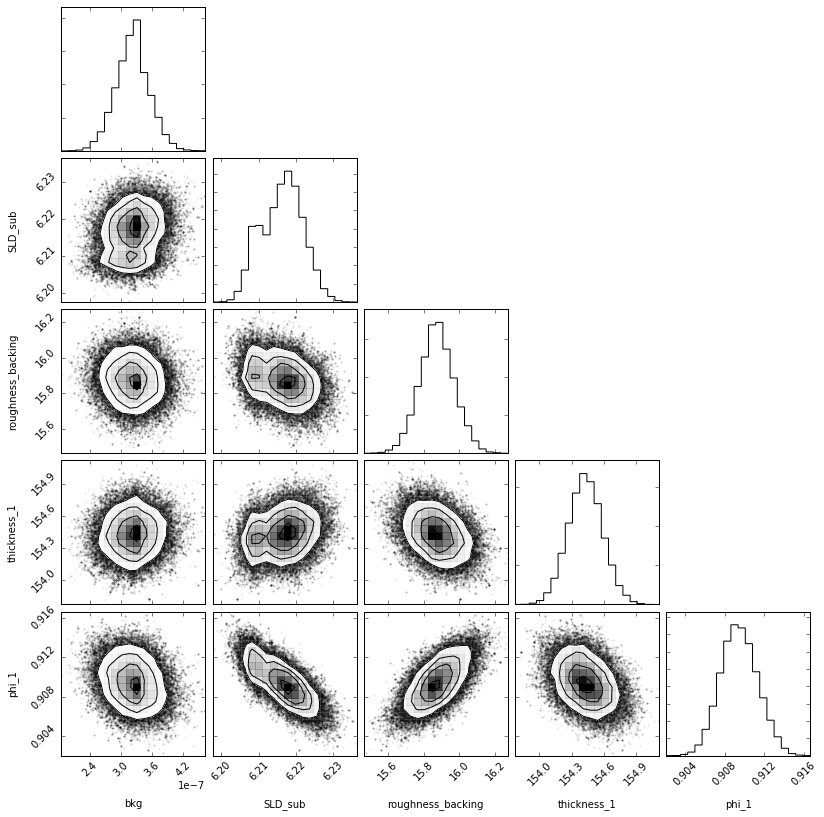

In [28]:
f = corner.corner(e.flatchain)

In [29]:
def pgen(parameters, flatchain, idx=None):
    # generator for all the different parameters from a flatchain.
    if idx is None:
        idx = range(np.size(flatchain, 0))
    for i in idx:
        vec = flatchain.iloc[i]
        for var_name in flatchain.columns:
            parameters[var_name].value = flatchain.iloc[i][var_name]
        yield parameters

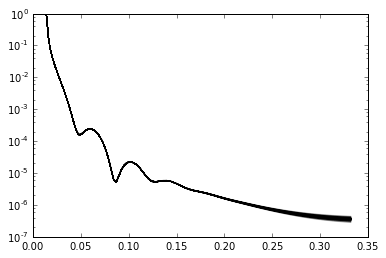

In [32]:
for pars in pgen(e.params,
                 e.flatchain,
                 idx = np.random.choice(len(e.flatchain), size=500, replace=False)):
    plt.plot(d.x,a.model(d.x,pars), color="k", alpha=0.05)
plt.yscale("log")
    

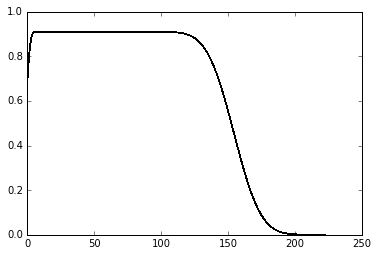

In [33]:
for pars in pgen(e.params,
                 e.flatchain,
                 idx = np.random.choice(len(e.flatchain), size=500, replace=False)):
    z, phi = a.vol_fraction(P)
    plt.plot(z,phi, color="k", alpha=0.05)